In [4]:
# Cell 1: Imports and Data Loading
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('augmented_bakery_data.csv')

# Encode categorical variables
le_product = LabelEncoder()
le_storage = LabelEncoder()

data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])
data['Storage_Condition_encoded'] = le_storage.fit_transform(data['Storage_Condition'])

# Print encoding mapping
print("Product Type Encoding:")
for i, label in enumerate(le_product.classes_):
    print(f"{label}: {i}")

print("\nStorage Condition Encoding:")
for i, label in enumerate(le_storage.classes_):
    print(f"{label}: {i}")

Product Type Encoding:
Bread: 0
Cookies: 1

Storage Condition Encoding:
Humid: 0
Open: 1
Wrapped: 2


In [5]:
# Cell 2: Data Preparation Function
def prepare_data(data, target_type='product', include_other_label=False):
    """
    Prepare data for classification
    
    Parameters:
    - data: DataFrame containing the data
    - target_type: 'product' or 'storage'
    - include_other_label: whether to include the other label as a feature
    
    Returns:
    - X: features
    - y: target variable
    """
    # Get base features (gains and phases)
    feature_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
    X = data[feature_cols].copy()
    
    # Add additional feature if requested
    if include_other_label:
        if target_type == 'product':
            X['storage_condition'] = data['Storage_Condition_encoded']
        else:
            X['product_type'] = data['Product_Type_encoded']
    
    # Select target
    y = data['Product_Type_encoded'] if target_type == 'product' else data['Storage_Condition_encoded']
    
    return X, y

In [6]:
# Cell 3: Model Definition with Hyperparameter Grids
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

models = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto', 0.1, 0.01]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'Neural Network': {
        'model': MLPClassifier(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10, 100],
            'solver': ['lbfgs', 'newton-cg', 'sag'],
            'multi_class': ['auto', 'ovr', 'multinomial']
        }
    }
}

In [7]:
# Cell 4: Model Training and Evaluation Function
def train_and_evaluate_model(X, y, model_name, model_dict, scaler=None):
    """
    Train and evaluate a model with hyperparameter tuning
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    if scaler is None:
        scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform GridSearch
    grid_search = GridSearchCV(
        model_dict['model'],
        model_dict['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit model
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate metrics
    results = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_accuracy': grid_search.score(X_test_scaled, y_test),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    return results, best_model, scaler

In [8]:
# Cell 5: Run Experiments
def run_classification_experiments(data, target_type):
    experiments = [
        {'name': f'{target_type} without additional features', 'include_other_label': False},
        {'name': f'{target_type} with additional features', 'include_other_label': True}
    ]
    
    results = {}
    
    for experiment in experiments:
        print(f"\nRunning experiment: {experiment['name']}")
        X, y = prepare_data(data, target_type, experiment['include_other_label'])
        
        experiment_results = {}
        scaler = StandardScaler()
        
        for model_name, model_dict in models.items():
            print(f"\nTraining {model_name}...")
            model_results, best_model, _ = train_and_evaluate_model(X, y, model_name, model_dict, scaler)
            experiment_results[model_name] = model_results
        
        results[experiment['name']] = experiment_results
    
    return results

# Run product type classification
product_results = run_classification_experiments(data, 'product')

# Run storage condition classification
storage_results = run_classification_experiments(data, 'storage')


Running experiment: product without additional features

Training SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Training Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Training KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Training Neural Network...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Training Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running experiment: product with additional features

Training SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Training Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Training KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Training Neural Network...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Training Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running experiment: stor

c:\Users\yohan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Running experiment: storage with additional features

Training SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Training Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Training KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Training Neural Network...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Training Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


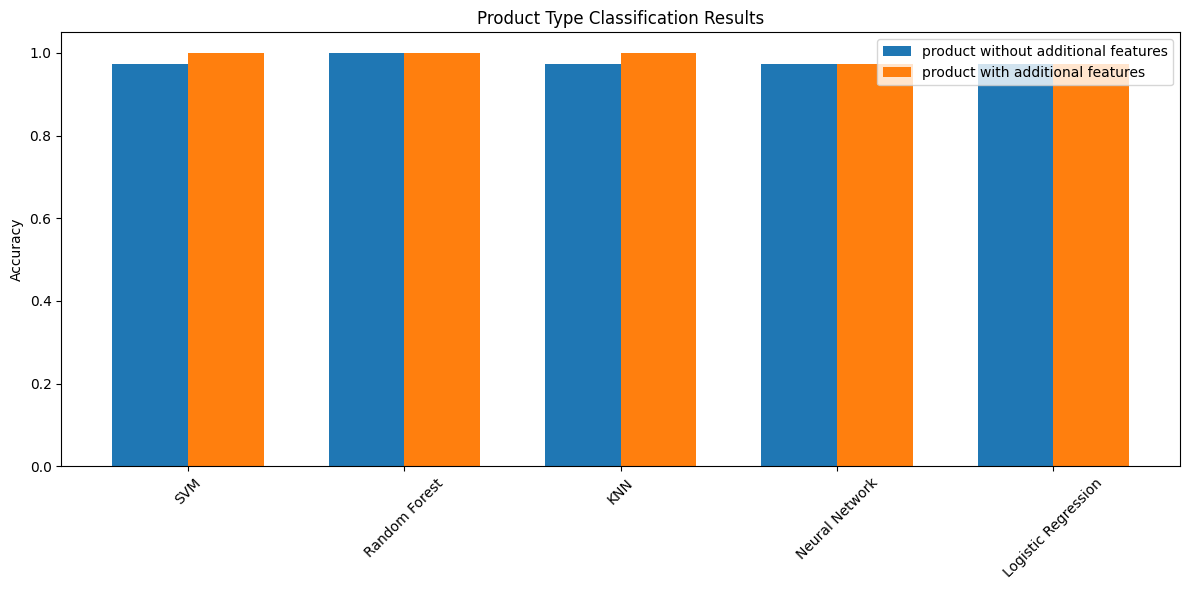

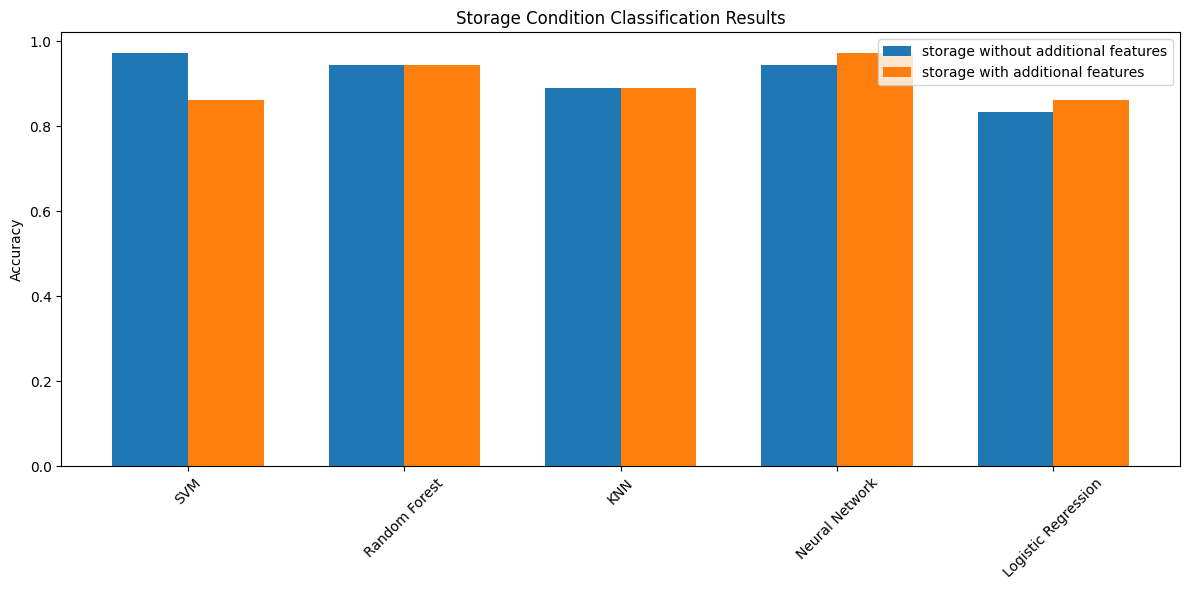

In [9]:
# Cell 6: Visualization Functions
def plot_results(results, title):
    """Plot comparison of model performances"""
    plt.figure(figsize=(12, 6))
    
    experiments = list(results.keys())
    models = list(results[experiments[0]].keys())
    
    x = np.arange(len(models))
    width = 0.35
    
    for i, experiment in enumerate(experiments):
        accuracies = [results[experiment][model]['test_accuracy'] for model in models]
        plt.bar(x + i*width, accuracies, width, label=experiment)
    
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(x + width/2, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot results
plot_results(product_results, 'Product Type Classification Results')
plot_results(storage_results, 'Storage Condition Classification Results')

In [10]:
# Cell 7: Save Results
def save_results(results, filename):
    """Save results to a file"""
    with open(filename, 'w') as f:
        for experiment, exp_results in results.items():
            f.write(f"\n{experiment}\n")
            f.write("="*50 + "\n")
            
            for model, model_results in exp_results.items():
                f.write(f"\n{model}\n")
                f.write("-"*30 + "\n")
                f.write(f"Best parameters: {model_results['best_params']}\n")
                f.write(f"Best CV score: {model_results['best_score']:.4f}\n")
                f.write(f"Test accuracy: {model_results['test_accuracy']:.4f}\n")
                f.write("\nClassification Report:\n")
                f.write(model_results['classification_report'])
                f.write("\n")

# Save results
save_results(product_results, 'product_classification_results.txt')
save_results(storage_results, 'storage_classification_results.txt')